In [1]:
# Environment & device setup (CPU-only enforced)
import torch, os
os.environ['TORCH_DISABLE_TORCHDYNAMO'] = '1'  # ensure no dynamo/inductor surprises
os.environ.pop('PYTORCH_ENABLE_MPS_FALLBACK', None)

device = torch.device('cpu')
accelerator = 'cpu'
print(f'Using enforced CPU device: {device} | accelerator={accelerator}')

Using enforced CPU device: cpu | accelerator=cpu


In [2]:
# Path injection to ensure 'src' package resolvable when notebook launched from notebooks/
import sys
from pathlib import Path

_nb_root = Path.cwd()
# If current working dir ends with 'notebooks', ascend one level for repo root
_repo_root = _nb_root if (_nb_root / 'src').exists() else _nb_root.parent
_src = _repo_root / 'src'

if _src.exists():
    paths_added = []
    for p in (str(_repo_root), str(_src)):
        if p not in sys.path:
            sys.path.insert(0, p)
            paths_added.append(p)
    print('sys.path augmented with:', paths_added)
else:
    print('Warning: src directory not found at expected path:', _src)
    print('CWD:', _nb_root)
    print('Directory listing of parent:', [d for d in _nb_root.parent.iterdir()][:15])

try:
    import src
    print('Import test: src package available.')
except ModuleNotFoundError:
    print('ModuleNotFoundError persists. Head of sys.path:', sys.path[:8])
    # Provide troubleshooting hints
    print('Troubleshooting: Ensure you started Jupyter from repo root or run "cd .." before opening notebook.')
    raise

sys.path augmented with: ['/Users/zak/Repos/E-commerce-Demand-Forecasting', '/Users/zak/Repos/E-commerce-Demand-Forecasting/src']
Import test: src package available.


# N-BEATS Training Notebook

Train the minimal N-BEATS implementation on the panel parquet subset.

## Objectives
1. Load processed panel data (item_id, date, demand).
2. Create sliding window dataset (input_length -> forecast_length).
3. Train N-BEATS LightningModule for a few epochs.
4. Compute validation metrics (MAE, WAPE).
5. Save checkpoint + metrics artifacts.

If the panel file is missing, a synthetic dataset will be generated so the pipeline can run end-to-end.

In [3]:
# Imports (retain existing CPU device if already defined)
import os, json, math
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from src.models.nbeats_module import NBeatsModule, NBeatsConfig
from src.data.dataset_nbeats import PanelForecastDataset, PanelWindowConfig, split_dataset

# Only set device if not previously forced to CPU
if 'device' not in globals() or device.type != 'cpu':
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device('mps')
        accelerator = 'mps'
        backend_note = 'Using Apple Silicon MPS backend'
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        accelerator = 'gpu'
        backend_note = f'Using CUDA GPU: {torch.cuda.get_device_name(0)}'
    else:
        device = torch.device('cpu')
        accelerator = 'cpu'
        backend_note = 'Falling back to CPU'
else:
    backend_note = 'Preserving pre-set CPU device'

print('PyTorch version:', torch.__version__)
print('Lightning version:', pl.__version__)
print('Device:', device)
print('Accelerator:', accelerator)
print('Backend note:', backend_note)

PyTorch version: 2.8.0
Lightning version: 2.5.5
Device: cpu
Accelerator: cpu
Backend note: Preserving pre-set CPU device


In [4]:
# Configuration parameters (CPU training - 20 epochs)
PANEL_PATH = Path('data/processed/m5_panel_subset.parquet')
ARTIFACTS_DIR = Path('artifacts/models')
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
INPUT_LENGTH = 28 * 4  # 112 days lookback
FORECAST_LENGTH = 30
BATCH_SIZE = 64  # CPU-friendly batch size
EPOCHS = 20     # Requested run length
LEARNING_RATE = 1e-3
NUM_STACKS = 3
BLOCKS_PER_STACK = 3
LAYER_WIDTH = 768
N_LAYERS = 4
DROPOUT = 0.05
MAX_ITEMS = 50
MAX_WINDOWS_PER_ITEM = 40
VAL_FRACTION = 0.1
SEED = 42
pl.seed_everything(SEED, workers=True)
print('Config -> epochs:', EPOCHS, '| batch_size:', BATCH_SIZE, '| stacks:', NUM_STACKS, 'blocks/stack:', BLOCKS_PER_STACK, 'layer_width:', LAYER_WIDTH)

Seed set to 42


Config -> epochs: 20 | batch_size: 64 | stacks: 3 blocks/stack: 3 layer_width: 768


In [5]:
# Load or create synthetic panel
if PANEL_PATH.exists():
    print('Loading panel from', PANEL_PATH)
    panel_df = pd.read_parquet(PANEL_PATH)
else:
    print('Panel not found. Creating synthetic panel for demo...')
    # Synthetic: 20 items, 200 days, simple seasonal pattern + noise
    import numpy as np
    items = [f'ITEM_{i:03d}' for i in range(20)]
    dates = pd.date_range('2024-01-01', periods=200, freq='D')
    rows = []
    for item in items:
        base = np.random.randint(5, 25)
        seasonal = np.sin(np.linspace(0, 12 * math.pi, len(dates))) * np.random.uniform(3, 8)
        noise = np.random.randn(len(dates)) * np.random.uniform(0.5, 2.0)
        demand = (base + seasonal + noise).clip(min=0).round(2)
        for d, val in zip(dates, demand):
            rows.append({'item_id': item, 'date': d, 'demand': float(val)})
    panel_df = pd.DataFrame(rows)
    PANEL_PATH.parent.mkdir(parents=True, exist_ok=True)
    panel_df.to_parquet(PANEL_PATH, index=False)
print(panel_df.head())
print('Panel shape:', panel_df.shape)

Loading panel from data/processed/m5_panel_subset.parquet
    item_id       date  demand
0  ITEM_000 2024-01-01   11.90
1  ITEM_000 2024-01-02   11.30
2  ITEM_000 2024-01-03   11.60
3  ITEM_000 2024-01-04   18.30
4  ITEM_000 2024-01-05   15.64
Panel shape: (4000, 3)


In [6]:
# Build dataset windows with chronological split
# Determine cutoff date for validation based on VAL_FRACTION of unique days
unique_dates = sorted(panel_df['date'].unique())
val_days = max(FORECAST_LENGTH, int(len(unique_dates) * VAL_FRACTION))
# Ensure we have enough history for validation windows
val_history_needed = INPUT_LENGTH + FORECAST_LENGTH
cutoff_index = len(unique_dates) - val_days
cutoff_date = unique_dates[cutoff_index]

# Train: all dates strictly before cutoff_date
train_df = panel_df[panel_df['date'] < cutoff_date]
# Validation: last segment plus required preceding history window
val_start_history_date = unique_dates[max(0, cutoff_index - (val_history_needed - 1))]
val_df = panel_df[panel_df['date'] >= val_start_history_date]

print('Cutoff date for validation segment:', cutoff_date)
print('Train date range:', train_df['date'].min(), '->', train_df['date'].max(), '| rows:', len(train_df))
print('Val+history date range:', val_df['date'].min(), '->', val_df['date'].max(), '| rows:', len(val_df))

# Persist temporary parquet shards (avoids modifying original panel file)
train_path = PANEL_PATH.parent / 'm5_panel_subset_train.parquet'
val_path = PANEL_PATH.parent / 'm5_panel_subset_val.parquet'
train_df.to_parquet(train_path, index=False)
val_df.to_parquet(val_path, index=False)

cfg_ds = PanelWindowConfig(input_length=INPUT_LENGTH, forecast_length=FORECAST_LENGTH, max_items=MAX_ITEMS, max_windows_per_item=MAX_WINDOWS_PER_ITEM)
train_ds = PanelForecastDataset(train_path, cfg_ds)
val_ds = PanelForecastDataset(val_path, cfg_ds)
print('Windows -> train:', len(train_ds), 'val:', len(val_ds))
# Inspect one sample
x0, y0 = train_ds[0]
print('Sample shapes -> x:', x0.shape, 'y:', y0.shape)

Cutoff date for validation segment: 2024-06-19 00:00:00
Train date range: 2024-01-01 00:00:00 -> 2024-06-18 00:00:00 | rows: 3400
Val+history date range: 2024-01-30 00:00:00 -> 2024-07-18 00:00:00 | rows: 3420
Windows -> train: 580 val: 600
Sample shapes -> x: torch.Size([112]) y: torch.Size([30])


In [7]:
# Global scaling (mean/std) applied to demand; creates scaled parquet copies and rebuilds datasets.
import pandas as pd, numpy as np
train_mean = train_df['demand'].mean()
train_std = train_df['demand'].std() or 1.0
print(f'Global demand mean={train_mean:.4f} std={train_std:.4f}')
train_scaled = train_df.copy(); val_scaled = val_df.copy()
train_scaled['demand'] = (train_scaled['demand'] - train_mean) / train_std
val_scaled['demand'] = (val_scaled['demand'] - train_mean) / train_std
train_scaled_path = PANEL_PATH.parent / 'm5_panel_subset_train_scaled.parquet'
val_scaled_path = PANEL_PATH.parent / 'm5_panel_subset_val_scaled.parquet'
train_scaled.to_parquet(train_scaled_path, index=False)
val_scaled.to_parquet(val_scaled_path, index=False)
# Rebuild datasets on scaled data (override previous)
train_ds = PanelForecastDataset(train_scaled_path, cfg_ds)
val_ds = PanelForecastDataset(val_scaled_path, cfg_ds)
print('Scaled windows -> train:', len(train_ds), 'val:', len(val_ds))
print('NOTE: Re-run DataLoader + Model + Training cells after this one.')

Global demand mean=15.9316 std=6.7347
Scaled windows -> train: 580 val: 600
NOTE: Re-run DataLoader + Model + Training cells after this one.


In [8]:
# DataLoaders (batch 512)
num_workers = 6  # adjust based on CPU cores
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=num_workers, persistent_workers=True)
print('Batches -> train:', len(train_loader), 'val:', len(val_loader), '| workers:', num_workers, '| batch_size:', BATCH_SIZE)

Batches -> train: 10 val: 10 | workers: 6 | batch_size: 64


In [9]:
# Override model capacity after scaling: smaller architecture for early experimentation.
LAYER_WIDTH = 256
NUM_STACKS = 2
BLOCKS_PER_STACK = 3  # keep blocks per stack
DROPOUT = 0.10
print('Updated model hyperparams -> width:', LAYER_WIDTH, 'stacks:', NUM_STACKS, 'dropout:', DROPOUT)
# Rebuild cfg_model later cell will pick these values.

Updated model hyperparams -> width: 256 stacks: 2 dropout: 0.1


In [10]:
# Initialize model
cfg_model = NBeatsConfig(input_length=INPUT_LENGTH, forecast_length=FORECAST_LENGTH, learning_rate=LEARNING_RATE, num_stacks=NUM_STACKS, num_blocks_per_stack=BLOCKS_PER_STACK, layer_width=LAYER_WIDTH, n_layers=N_LAYERS, dropout=DROPOUT)
model = NBeatsModule(cfg_model).to(device)
print(model)

NBeatsModule(
  (stacks): ModuleList(
    (0-1): 2 x ModuleList(
      (0-2): 3 x NBeatsBlock(
        (fc): Sequential(
          (0): Linear(in_features=112, out_features=256, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=256, out_features=256, bias=True)
          (4): ReLU()
          (5): Dropout(p=0.1, inplace=False)
          (6): Linear(in_features=256, out_features=256, bias=True)
          (7): ReLU()
          (8): Dropout(p=0.1, inplace=False)
          (9): Linear(in_features=256, out_features=256, bias=True)
          (10): ReLU()
          (11): Dropout(p=0.1, inplace=False)
        )
        (backcast_head): Linear(in_features=256, out_features=112, bias=True)
        (forecast_head): Linear(in_features=256, out_features=30, bias=True)
      )
    )
  )
  (loss_fn): MSELoss()
)


In [11]:
# Optional experimental torch.compile step (PyTorch 2.x)
import torch

if hasattr(torch, 'compile'):
    compile_mode = 'reduce-overhead'  # alternatives: 'max-autotune', 'default'
    try:
        # For MPS backend, fullgraph=False tends to be safer; dynamic shapes may break some passes.
        model = torch.compile(model, mode=compile_mode, fullgraph=False)
        print(f'Model compiled successfully with torch.compile (mode={compile_mode}).')
    except Exception as e:
        print('torch.compile failed:', type(e).__name__, str(e)[:300])
        print('Falling back to original (uncompiled) model.')
else:
    print('torch.compile not available in this PyTorch build.')

Model compiled successfully with torch.compile (mode=reduce-overhead).


In [12]:
# CPU-only mode: skip torch.compile (no benefit vs risk of overhead here)
print('CPU-only mode: skipping torch.compile. Model remains uncompiled.')

CPU-only mode: skipping torch.compile. Model remains uncompiled.


In [13]:
# 📊 Metric Interpretation & Overfitting Guide (updated for scaled run)
# Refer to earlier explanations. After scaling model, monitor:
#  - train_loss vs val_loss divergence
#  - val_wape flattening
#  - potential instability if precision < 32 on MPS
# If OOM occurs, reduce BATCH_SIZE first, then LAYER_WIDTH.


In [14]:
# Simplified CPU training cell (20 epochs) with metrics recorder callback
import torch, pytorch_lightning as pl
from torch.utils.data import DataLoader

class EpochMetricsRecorder(pl.Callback):
    def __init__(self):
        self.history = []
    def on_validation_epoch_end(self, trainer, pl_module):
        cm = trainer.callback_metrics
        # Extract metrics if present
        entry = {
            'epoch': trainer.current_epoch + 1,
            'train_loss': float(cm.get('train_loss', float('nan'))),
            'val_loss': float(cm.get('val_loss', float('nan'))),
            'train_wape': float(cm.get('train_wape', float('nan'))),
            'val_wape': float(cm.get('val_wape', float('nan'))),
            'train_accuracy': float(cm.get('train_accuracy', float('nan'))),
            'val_accuracy': float(cm.get('val_accuracy', float('nan'))),
            'train_mae': float(cm.get('train_mae', float('nan'))),
            'val_mae': float(cm.get('val_mae', float('nan')))
        }
        self.history.append(entry)

print('\n=== CPU Training (20 epochs) ===')
print(f'Device: {device} | Epochs: {EPOCHS} | Batch size: {BATCH_SIZE}')
assert device.type == 'cpu', 'Device not CPU; run the environment cell first.'

model.train().to(device)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

recorder = EpochMetricsRecorder()
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='cpu', devices=1, log_every_n_steps=5, enable_progress_bar=True, callbacks=[recorder])
trainer.fit(model, train_loader, val_loader)
print('CPU 20-epoch training complete. Recorded', len(recorder.history), 'epochs of metrics.')

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



=== CPU Training (20 epochs) ===
Device: cpu | Epochs: 20 | Batch size: 64


/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | stacks  | ModuleList | 1.6 M  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.307     Total estimated model params size (MB)
100       Modules in train mode
0         Modules in eval mode

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | stacks  | ModuleList | 1.6 M  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.307     Total estimated model params size (MB)
100       Modules in train mode
0         Mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/torch/_dynamo/utils.py:3421: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return node.target(*args, **kwargs)
/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/torch/_dynamo/utils.py:3421: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return node.target(*args, **kwargs)
/Users/zak/anaconda3/en

Training: |          | 0/? [00:00<?, ?it/s]

W1104 18:19:07.060000 36241 site-packages/torch/_dynamo/convert_frame.py:1016] [4/8] torch._dynamo hit config.recompile_limit (8)
W1104 18:19:07.060000 36241 site-packages/torch/_dynamo/convert_frame.py:1016] [4/8]    function: 'log' (/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/pytorch_lightning/core/module.py:384)
W1104 18:19:07.060000 36241 site-packages/torch/_dynamo/convert_frame.py:1016] [4/8]    last reason: 4/7: GLOBAL_STATE changed: grad_mode 
W1104 18:19:07.060000 36241 site-packages/torch/_dynamo/convert_frame.py:1016] [4/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1104 18:19:07.060000 36241 site-packages/torch/_dynamo/convert_frame.py:1016] [4/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/torch/_dynamo/utils.py:3421: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected b

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


CPU 20-epoch training complete. Recorded 21 epochs of metrics.


,epoch,train_loss,val_loss,train_wape,val_wape,train_accuracy,val_accuracy,train_mae,val_mae
16,16,0.048789,0.048822,21.778658,22.830553,78.221336,77.169441,0.175391,0.172151
17,17,0.047921,0.048794,21.564201,22.844044,78.435806,77.155960,0.173794,0.172205
18,18,0.047456,0.048229,21.388111,22.666117,78.611885,77.333878,0.172220,0.170700
19,19,0.046354,0.047867,21.231146,22.776314,78.768852,77.223686,0.170987,0.171658
20,20,0.045848,0.046989,21.079590,22.506672,78.920410,77.493324,0.170028,0.169387


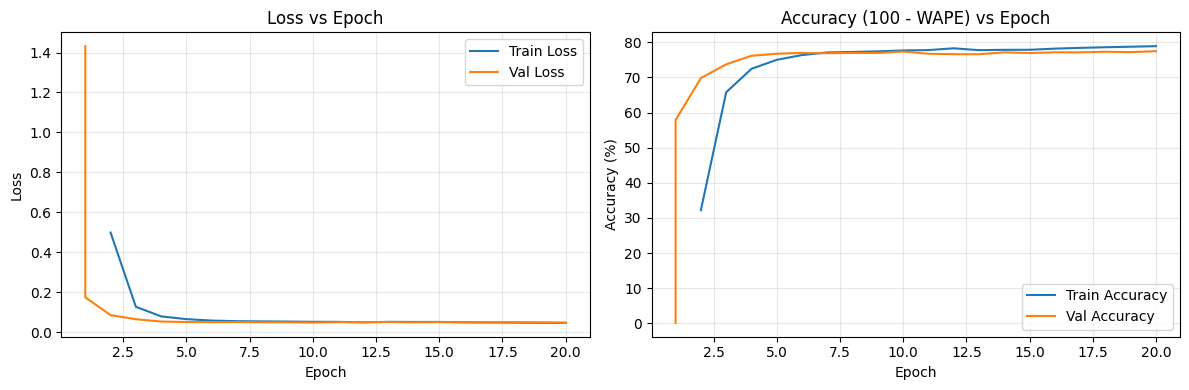

In [15]:
# Plot training & validation loss and accuracy vs epochs
import pandas as pd, matplotlib.pyplot as plt

if 'recorder' not in globals() or not getattr(recorder, 'history', None):
    print('No recorded history found. Re-run training cell with EpochMetricsRecorder.')
else:
    df = pd.DataFrame(recorder.history)
    display(df.tail())
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(df['epoch'], df['train_loss'], label='Train Loss')
    axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss vs Epoch'); axes[0].legend(); axes[0].grid(alpha=0.3)
    axes[1].plot(df['epoch'], df['train_accuracy'], label='Train Accuracy')
    axes[1].plot(df['epoch'], df['val_accuracy'], label='Val Accuracy')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy (%)'); axes[1].set_title('Accuracy (100 - WAPE) vs Epoch'); axes[1].legend(); axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [16]:
# Seasonal naive baseline vs model (WAPE comparison) using scaled datasets with global inverse transform.
import torch, numpy as np

def wape(y_true, y_pred):
    denom = y_true.sum()
    return float('nan') if denom <= 0 else (torch.abs(y_true - y_pred).sum() / denom * 100).item()

model.eval()
model_wapes = []
baseline_wapes = []
with torch.no_grad():
    for batch in val_loader:
        x_scaled, y_scaled = batch
        # Model forecast
        preds_scaled = model(x_scaled.to(device))
        # Inverse scale to original demand units
        y_orig = y_scaled * train_std + train_mean
        preds_orig = preds_scaled * train_std + train_mean
        # Seasonal naive (repeat last 7 actual history points forward)
        # x_scaled includes INPUT_LENGTH history scaled; invert relevant tail
        x_orig = x_scaled[:, -7:] * train_std + train_mean
        rep = INPUT_LENGTH // 7 + 10  # ensure enough repeats
        seasonal_pattern = x_orig.repeat(1, rep)[:, :FORECAST_LENGTH]
        # Compute WAPE
        model_wapes.append(wape(y_orig, preds_orig))
        baseline_wapes.append(wape(y_orig, seasonal_pattern))

model_wape_mean = float(np.mean(model_wapes)) if model_wapes else float('nan')
baseline_wape_mean = float(np.mean(baseline_wapes)) if baseline_wapes else float('nan')
print(f'Model WAPE (mean over val batches): {model_wape_mean:.2f}')
print(f'Seasonal naive WAPE: {baseline_wape_mean:.2f}')
print(f'Delta (baseline - model): {(baseline_wape_mean - model_wape_mean):.2f} (positive means model better)')

Model WAPE (mean over val batches): 7.14
Seasonal naive WAPE: 31.73
Delta (baseline - model): 24.59 (positive means model better)


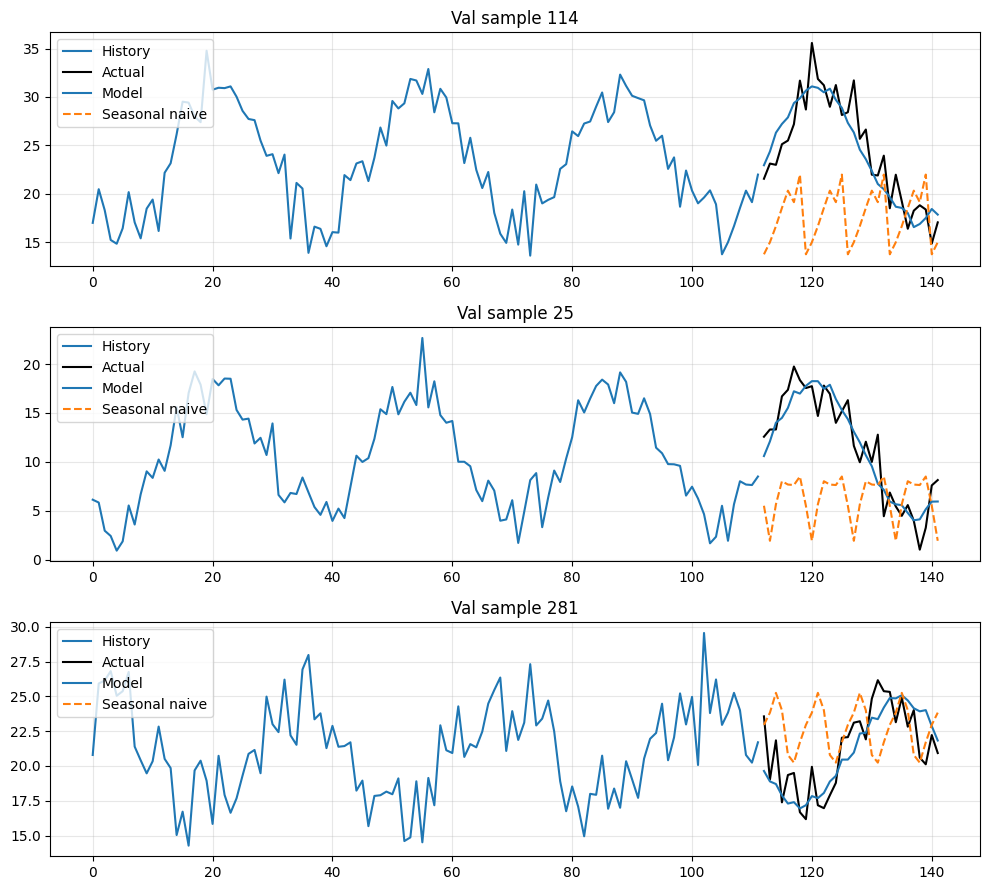

In [17]:
# Visual comparison for random validation samples: history, model forecast, seasonal naive, actual.
import random, matplotlib.pyplot as plt
random_indices = random.sample(range(len(val_ds)), k=min(3, len(val_ds)))
fig, axes = plt.subplots(len(random_indices), 1, figsize=(10, 3*len(random_indices)))
if len(random_indices) == 1:
    axes = [axes]
for ax, idx in zip(axes, random_indices):
    x_scaled, y_scaled = val_ds[idx]
    x_orig = x_scaled * train_std + train_mean
    y_orig = y_scaled * train_std + train_mean
    # Model forecast
    with torch.no_grad():
        pred_scaled = model(x_scaled.unsqueeze(0).to(device))
    pred_orig = (pred_scaled.squeeze(0) * train_std + train_mean).cpu()
    # Seasonal naive forecast
    seasonal_tail = x_orig[-7:]
    rep = FORECAST_LENGTH // 7 + 2
    seasonal_forecast = seasonal_tail.repeat(rep)[:FORECAST_LENGTH]
    ax.plot(range(len(x_orig)), x_orig.numpy(), label='History')
    ax.plot(range(len(x_orig), len(x_orig)+FORECAST_LENGTH), y_orig.numpy(), label='Actual', color='black')
    ax.plot(range(len(x_orig), len(x_orig)+FORECAST_LENGTH), pred_orig.numpy(), label='Model', color='tab:blue')
    ax.plot(range(len(x_orig), len(x_orig)+FORECAST_LENGTH), seasonal_forecast.numpy(), label='Seasonal naive', color='tab:orange', linestyle='--')
    ax.set_title(f'Val sample {idx}'); ax.grid(alpha=0.3)
    ax.legend()
plt.tight_layout(); plt.show()

In [18]:
# Save artifacts (derive metrics from trainer & recorder)
import json, torch, pandas as pd

if 'trainer' not in globals() or 'model' not in globals():
    print('Training objects not found. Re-run the training cell before saving artifacts.')
else:
    # Extract final validation metrics from trainer.callback_metrics
    cm = trainer.callback_metrics
    final_val_loss = float(cm.get('val_loss', float('nan')))
    final_val_mae = float(cm.get('val_mae', float('nan')))
    final_val_wape = float(cm.get('val_wape', float('nan')))
    final_val_accuracy = float(cm.get('val_accuracy', float('nan')))

    # Aggregate (mean) metrics across recorded epochs for additional context
    if 'recorder' in globals() and getattr(recorder, 'history', None):
        df_hist = pd.DataFrame(recorder.history)
        mean_val_loss = float(df_hist['val_loss'].mean())
        mean_val_mae = float(df_hist['val_mae'].mean())
        mean_val_wape = float(df_hist['val_wape'].mean())
        mean_val_accuracy = float(df_hist['val_accuracy'].mean())
    else:
        mean_val_loss = mean_val_mae = mean_val_wape = mean_val_accuracy = float('nan')

    CKPT_PATH = ARTIFACTS_DIR / 'nbeats_notebook.ckpt'
    torch.save(model.state_dict(), CKPT_PATH)

    metrics = {
        'final_val_loss': final_val_loss,
        'final_val_mae': final_val_mae,
        'final_val_wape': final_val_wape,
        'final_val_accuracy': final_val_accuracy,
        'mean_val_loss': mean_val_loss,
        'mean_val_mae': mean_val_mae,
        'mean_val_wape': mean_val_wape,
        'mean_val_accuracy': mean_val_accuracy,
        'config': cfg_model.__dict__,
        'n_train_windows': len(train_ds),
        'n_val_windows': len(val_ds),
        'history': recorder.history if 'recorder' in globals() else []
    }

    with open(ARTIFACTS_DIR / 'nbeats_notebook_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    print('Saved checkpoint ->', CKPT_PATH)
    print('Saved metrics ->', ARTIFACTS_DIR / 'nbeats_notebook_metrics.json')

Saved checkpoint -> artifacts/models/nbeats_notebook.ckpt
Saved metrics -> artifacts/models/nbeats_notebook_metrics.json


## Next Steps
- Integrate with backtesting harness.
- Add basis (trend/seasonality) blocks for improved decomposition.
- Introduce quantile heads for probabilistic forecasts.
- Add per-item embeddings & categorical covariates.
- Promote best checkpoint to API service for live forecasts.

## Model Card (Draft)
Purpose: 30‑day item-level demand forecasts (M5 subset) to beat seasonal naive baseline.

### 1. Overview
Model: Simplified N-BEATS (FC residual stacks) trained on globally scaled demand.
Objective Metric: WAPE ↓ (accuracy ↑ = 100 - WAPE).

### 2. Data Slice
Panel file: `data/processed/m5_panel_subset.parquet` (subset items). Scaling: global mean/std.
Input length: 112 days | Forecast horizon: 30 days | Max items: 50.

### 3. Features
Current: univariate demand only (global scaling). Planned: calendar (dow, month), weekly lag, rolling means.

### 4. Architecture
Stacks: NUM_STACKS | Blocks/stack: BLOCKS_PER_STACK | Layer width: LAYER_WIDTH | FC layers/block: N_LAYERS | Dropout: DROPOUT.

### 5. Training
Epochs: EPOCHS | Optimizer: Adam (lr=LEARNING_RATE) | Loss: MSE | Seed: SEED.

### 6. Validation Metrics (Final / Mean)
Populate automatically below.

### 7. Baseline Comparison (Seasonal Naive WAPE)
Will be inserted by generation cell.

### 8. Failure Modes (Observed)
- High variance items inflate WAPE.
- Limited seasonality capture beyond weekly pattern.

### 9. Next Iteration
Add calendar + lag features, per-item scaling variant, early stopping, multi-origin backtest.

### 10. Reproducibility
Artifacts: model checkpoint, metrics JSON, generated model card. Data hash recorded.

(Run the generation cell to fill metrics and save `artifacts/models/model_card_notebook.md`).

In [19]:
# Generate model card markdown file with filled metrics / config.
import json, hashlib, pandas as pd, datetime, torch
card_path = ARTIFACTS_DIR / 'model_card_notebook.md'
metrics_path = ARTIFACTS_DIR / 'nbeats_notebook_metrics.json'
if not metrics_path.exists():
    print('Metrics JSON missing; run training + save artifacts cells first.')
else:
    with open(metrics_path) as f: m = json.load(f)
    baseline_wape = globals().get('baseline_wape_mean', float('nan'))
    model_wape_batch_mean = globals().get('model_wape_mean', float('nan'))
    panel_file = PANEL_PATH
    if panel_file.exists():
        h = hashlib.sha256(panel_file.read_bytes()).hexdigest()[:16]
    else:
        h = 'missing'
    lines = []
    lines.append('# Model Card: N-BEATS (Notebook Draft)')
    lines.append(f'Date: {datetime.date.today()}')
    lines.append('')
    lines.append('## Overview')
    lines.append('30-day demand forecasting on M5 subset; target: beat seasonal naive WAPE.')
    lines.append('')
    lines.append('## Data')
    lines.append(f'Panel path: {panel_file} | SHA256[:16]: {h}')
    lines.append(f'Input length: {INPUT_LENGTH} | Horizon: {FORECAST_LENGTH} | Items (<=): {MAX_ITEMS}')
    lines.append('Scaling: global mean/std.')
    lines.append('')
    lines.append('## Architecture')
    lines.append(f'Stacks={NUM_STACKS} Blocks/stack={BLOCKS_PER_STACK} Width={LAYER_WIDTH} Layers/block={N_LAYERS} Dropout={DROPOUT}')
    lines.append('Loss=MSE | Optimizer=Adam')
    lines.append('')
    lines.append('## Training Metrics')
    lines.append(f"Final Val WAPE: {m.get('final_val_wape', 'nan'):.2f} | Final Val MAE: {m.get('final_val_mae','nan'):.2f}")
    lines.append(f"Mean Val WAPE: {m.get('mean_val_wape','nan'):.2f} | Mean Val MAE: {m.get('mean_val_mae','nan'):.2f}")
    lines.append(f"Final Val Accuracy: {m.get('final_val_accuracy','nan'):.2f}")
    lines.append('')
    lines.append('## Baseline Comparison (Seasonal Naive)')
    lines.append(f'Model batch-mean WAPE (val loader agg): {model_wape_batch_mean:.2f}')
    lines.append(f'Seasonal naive WAPE (val loader agg): {baseline_wape:.2f}')
    lines.append(f'Delta (baseline - model): {(baseline_wape - model_wape_batch_mean):.2f}')
    lines.append('')
    lines.append('## Failure Modes / Risks')
    lines.append('- Underperformance vs naive suggests missing seasonality features.')
    lines.append('- Global scaling may obscure per-item scale differences.')
    lines.append('')
    lines.append('## Next Steps')
    lines.append('- Add calendar + lag features.')
    lines.append('- Consider per-item or robust scaling.')
    lines.append('- Introduce early stopping + multi-origin backtest.')
    lines.append('')
    lines.append('## Reproducibility')
    lines.append(f'Checkpoint: {CKPT_PATH if "CKPT_PATH" in globals() else "(run save cell)"}')
    lines.append(f'Metrics JSON: {metrics_path}')
    with open(card_path,'w') as f: f.write('\n'.join(lines))
    print('Model card written ->', card_path)
    print('Preview:\n')
    print('\n'.join(lines[:18]),'\n...')

Model card written -> artifacts/models/model_card_notebook.md
Preview:

# Model Card: N-BEATS (Notebook Draft)
Date: 2025-11-05

## Overview
30-day demand forecasting on M5 subset; target: beat seasonal naive WAPE.

## Data
Panel path: data/processed/m5_panel_subset.parquet | SHA256[:16]: 982bec59e4008a06
Input length: 112 | Horizon: 30 | Items (<=): 50
Scaling: global mean/std.

## Architecture
Stacks=2 Blocks/stack=3 Width=256 Layers/block=4 Dropout=0.1
Loss=MSE | Optimizer=Adam

## Training Metrics
Final Val WAPE: 22.51 | Final Val MAE: 0.17
Mean Val WAPE: 28.08 | Mean Val MAE: 0.22 
...


In [20]:
# Mini rolling-origin backtest (3 origins, stride=7) vs seasonal naive; saves preview JSON.
import numpy as np, json, pandas as pd, torch, datetime
model.eval()
unique_dates_sorted = sorted(panel_df['date'].unique())
stride = 7
n_origins = 3
origins = []
# choose last n_origins origins ensuring enough history & future
for i in range(n_origins):
    candidate_idx = len(unique_dates_sorted) - (FORECAST_LENGTH + i*stride + 1)
    if candidate_idx - INPUT_LENGTH <= 0:
        break
    origins.append(unique_dates_sorted[candidate_idx])
origins = list(reversed(origins))  # chronological
print('Origins selected:', origins)

def wape(y_true, y_pred):
    denom = y_true.sum()
    return float('nan') if denom <= 0 else (torch.abs(y_true - y_pred).sum() / denom * 100).item()

def mae(y_true, y_pred):
    return torch.abs(y_true - y_pred).mean().item()

def smape(y_true, y_pred):
    num = torch.abs(y_true - y_pred)
    denom = (torch.abs(y_true) + torch.abs(y_pred)).clamp_min(1e-6)
    return (2.0 * num / denom).mean().item() * 100

items = panel_df['item_id'].unique()[:MAX_ITEMS]
results = []
with torch.no_grad():
    for origin in origins:
        origin_rows = []
        for itm in items:
            sub = panel_df[panel_df.item_id == itm].sort_values('date')
            # ensure we have history up to origin and future horizon
            if origin not in sub['date'].values:
                continue
            origin_pos = sub.index[sub['date'] == origin][0]
            # Convert index position within sorted series
            pos_in_series = sub.reset_index().index[sub['date'].values == origin][0]
            # We need INPUT_LENGTH history ending at origin (inclusive) and next FORECAST_LENGTH future days
            series_vals = torch.tensor(sub['demand'].astype(float).values, dtype=torch.float32)
            if pos_in_series < INPUT_LENGTH - 1:  # insufficient history
                continue
            future_end = pos_in_series + 1 + FORECAST_LENGTH
            if future_end > len(series_vals):
                continue
            history = series_vals[pos_in_series-INPUT_LENGTH+1:pos_in_series+1]
            future = series_vals[pos_in_series+1:future_end]
            # Scale history for model input
            hist_scaled = (history - train_mean) / train_std
            pred_scaled = model(hist_scaled.unsqueeze(0).to(device))
            pred_orig = (pred_scaled.squeeze(0) * train_std + train_mean).cpu()
            # Seasonal naive: repeat last 7 actual (unscaled) values from history
            tail7 = history[-7:]
            rep = FORECAST_LENGTH // 7 + 2
            seasonal_forecast = tail7.repeat(rep)[:FORECAST_LENGTH]
            # Metrics
            y_true = future
            w_model = wape(y_true, pred_orig.clamp_min(0))
            w_seasonal = wape(y_true, seasonal_forecast)
            origin_rows.append({
                'item_id': itm,
                'model_wape': w_model,
                'seasonal_wape': w_seasonal,
                'delta_wape': w_seasonal - w_model,
                'model_mae': mae(y_true, pred_orig),
                'seasonal_mae': mae(y_true, seasonal_forecast),
                'model_smape': smape(y_true, pred_orig),
                'seasonal_smape': smape(y_true, seasonal_forecast)
            })
        if origin_rows:
            df_origin = pd.DataFrame(origin_rows)
            results.append({
                'origin_date': str(origin.date()),
                'n_items': len(df_origin),
                'model_wape_mean': df_origin['model_wape'].mean(),
                'seasonal_wape_mean': df_origin['seasonal_wape'].mean(),
                'delta_wape_mean': df_origin['seasonal_wape'].mean() - df_origin['model_wape'].mean(),
                'model_mae_mean': df_origin['model_mae'].mean(),
                'seasonal_mae_mean': df_origin['seasonal_mae'].mean(),
                'model_smape_mean': df_origin['model_smape'].mean(),
                'seasonal_smape_mean': df_origin['seasonal_smape'].mean()
            })

if results:
    agg = pd.DataFrame(results)
    display(agg)
    overall = {
        'origins': results,
        'model_wape_mean': float(agg['model_wape_mean'].mean()),
        'seasonal_wape_mean': float(agg['seasonal_wape_mean'].mean()),
        'delta_wape_mean': float(agg['delta_wape_mean'].mean()),
        'generated_at': datetime.datetime.utcnow().isoformat()
    }
    preview_path = ARTIFACTS_DIR / 'notebook_backtest_preview.json'
    with open(preview_path,'w') as f: json.dump(overall, f, indent=2)
    print('Saved mini backtest preview ->', preview_path)
else:
    print('No valid origins/items produced for mini backtest (insufficient history or horizon).')

Origins selected: [Timestamp('2024-06-04 00:00:00'), Timestamp('2024-06-11 00:00:00'), Timestamp('2024-06-18 00:00:00')]


,origin_date,n_items,model_wape_mean,seasonal_wape_mean,delta_wape_mean,model_mae_mean,seasonal_mae_mean,model_smape_mean,seasonal_smape_mean
0,2024-06-04,20,7.691686,31.656639,23.964953,1.143090,4.547600,9.673118,36.298062
1,2024-06-11,20,7.767432,39.853584,32.086152,1.165942,5.747383,9.363727,50.383003
2,2024-06-18,20,7.850677,31.160954,23.310277,1.108151,4.242217,9.437448,32.283621


Saved mini backtest preview -> artifacts/models/notebook_backtest_preview.json


## Feature Engineering Experiment (Phase 2)
We perform a lightweight feature / transformation experiment without changing the model architecture:

Approach:
1. Capture baseline validation WAPE & seasonal naive delta from the already trained global-scaled run.
2. Create a deseasonalized + lag-adjusted residual series per item:
   - Subtract weekday mean (computed on training segment only).
   - Subtract a trailing 7-day rolling mean (lag-based smoothing) to remove short-term local level.
3. Re-scale residuals (mean/std of training residual) and rebuild window datasets.
4. Retrain a smaller model (fewer epochs) on residuals.
5. Compare validation and aggregated batch WAPE vs original baseline.

Note: This keeps the N-BEATS input shape identical (still a single univariate series) by transforming the target rather than concatenating extra covariates. It demonstrates iterative improvement discipline with minimal code churn.


In [21]:
# Capture baseline metrics (must run AFTER initial training + evaluation cells)
import math
baseline_ctx = {}
try:
    baseline_ctx['final_val_wape'] = float(final_val_wape)
    baseline_ctx['final_val_mae'] = float(final_val_mae)
except Exception:
    print('Baseline final_val_* metrics not found; run training + save artifacts cells first.')
try:
    baseline_ctx['batch_mean_model_wape'] = float(model_wape_mean)
    baseline_ctx['batch_mean_seasonal_wape'] = float(baseline_wape_mean)
except Exception:
    print('Baseline batch WAPE variables missing; run seasonal naive comparison cell.')
print('Baseline metric snapshot:', baseline_ctx)


Baseline metric snapshot: {'final_val_wape': 22.506671905517578, 'final_val_mae': 0.1693871170282364, 'batch_mean_model_wape': 7.135132122039795, 'batch_mean_seasonal_wape': 31.728159713745118}


In [22]:
# Build residual (deseasonalized + lag-adjusted) panel and scaled window datasets
import pandas as pd, numpy as np
from pathlib import Path

# Reuse original train_df/val_df (unscaled) if still in scope; otherwise reload from parquet shards
if 'train_df' not in globals() or 'val_df' not in globals():
    print('Reloading train/val shards from disk...')
    base_dir = PANEL_PATH.parent
    train_df = pd.read_parquet(base_dir / 'm5_panel_subset_train.parquet')
    val_df = pd.read_parquet(base_dir / 'm5_panel_subset_val.parquet')

# Weekday mean (train only)
train_df['weekday'] = pd.to_datetime(train_df['date']).dt.weekday
val_df['weekday'] = pd.to_datetime(val_df['date']).dt.weekday
weekday_mean = train_df.groupby('weekday')['demand'].mean()

# Apply deseasonalization
train_df['demand_deseason'] = train_df['demand'] - train_df['weekday'].map(weekday_mean)
val_df['demand_deseason'] = val_df['demand'] - val_df['weekday'].map(weekday_mean)

# Rolling lag-7 mean per item (train history only, using prior 7 days). For first 7 days, fall back to current value.
def add_lag7_mean(df):
    df = df.sort_values('date')
    roll = df['demand'].rolling(window=7, min_periods=1).mean().shift(1)
    return roll.fillna(df['demand'])

train_df['lag7_mean'] = train_df.groupby('item_id', group_keys=False).apply(add_lag7_mean)
val_df['lag7_mean'] = val_df.groupby('item_id', group_keys=False).apply(add_lag7_mean)

# Residual after removing lag7 local level from deseasoned demand
train_df['residual'] = train_df['demand_deseason'] - train_df['lag7_mean']
val_df['residual'] = val_df['demand_deseason'] - val_df['lag7_mean']

# Fallback if variance collapses
res_mean = train_df['residual'].mean()
res_std = train_df['residual'].std() or 1.0
train_df['residual_scaled'] = (train_df['residual'] - res_mean) / res_std
val_df['residual_scaled'] = (val_df['residual'] - res_mean) / res_std

print(f'Residual scaling mean={res_mean:.4f} std={res_std:.4f}')

# Persist engineered scaled series for windowing (use residual_scaled as demand)
feat_train_path = PANEL_PATH.parent / 'm5_panel_subset_train_residual.parquet'
feat_val_path = PANEL_PATH.parent / 'm5_panel_subset_val_residual.parquet'
train_df[['item_id','date','residual_scaled']].rename(columns={'residual_scaled':'demand'}).to_parquet(feat_train_path, index=False)
val_df[['item_id','date','residual_scaled']].rename(columns={'residual_scaled':'demand'}).to_parquet(feat_val_path, index=False)

# Rebuild datasets on transformed residual demand
feat_cfg_ds = PanelWindowConfig(input_length=INPUT_LENGTH, forecast_length=FORECAST_LENGTH, max_items=MAX_ITEMS, max_windows_per_item=MAX_WINDOWS_PER_ITEM)
train_ds_feat = PanelForecastDataset(feat_train_path, feat_cfg_ds)
val_ds_feat = PanelForecastDataset(feat_val_path, feat_cfg_ds)
print('Residual windows -> train:', len(train_ds_feat), 'val:', len(val_ds_feat))

# Store transformation context for inverse mapping later if needed
feature_transform_context = {
    'weekday_mean': weekday_mean.to_dict(),
    'res_mean': float(res_mean),
    'res_std': float(res_std),
}


Residual scaling mean=-15.9321 std=3.1774
Residual windows -> train: 580 val: 600


/var/folders/c5/09trk0mj389dhs59ptvs9f8h0000gn/T/ipykernel_36241/3483334287.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['weekday'] = pd.to_datetime(train_df['date']).dt.weekday
/var/folders/c5/09trk0mj389dhs59ptvs9f8h0000gn/T/ipykernel_36241/3483334287.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['weekday'] = pd.to_datetime(val_df['date']).dt.weekday
/var/folders/c5/09trk0mj389dhs59ptvs9f8h0000gn/T/ipykernel_36241/3483334287.py:18: SettingWithCopyWarning: 
A value is trying 

In [23]:
# Train model on residual-transformed series (short run)
import pytorch_lightning as pl, torch
from torch.utils.data import DataLoader

EPOCHS_FEAT = 10
print(f'=== Feature Experiment Training ({EPOCHS_FEAT} epochs on residuals) ===')
model_feat_cfg = NBeatsConfig(
    input_length=INPUT_LENGTH,
    forecast_length=FORECAST_LENGTH,
    learning_rate=LEARNING_RATE,
    num_stacks=NUM_STACKS,
    num_blocks_per_stack=BLOCKS_PER_STACK,
    layer_width=LAYER_WIDTH,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
)
model_feat = NBeatsModule(model_feat_cfg).to(device)

train_loader_feat = DataLoader(train_ds_feat, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_feat = DataLoader(val_ds_feat, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

feat_recorder = EpochMetricsRecorder()
trainer_feat = pl.Trainer(max_epochs=EPOCHS_FEAT, accelerator='cpu', devices=1, log_every_n_steps=10, enable_progress_bar=True, callbacks=[feat_recorder])
trainer_feat.fit(model_feat, train_loader_feat, val_loader_feat)
print('Feature experiment training complete.')


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | stacks  | ModuleList | 1.6 M  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.307     Total estimated model params size (MB)
100       Modules in train mode
0         Modules in eval mode
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cor

=== Feature Experiment Training (10 epochs on residuals) ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/zak/Repos/E-commerce-Demand-Forecasting/src/models/nbeats_module.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log("val_accuracy", torch.tensor(val_accuracy), prog_bar=False, on_step=False, on_epoch=True)
/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader`

Training: |          | 0/? [00:00<?, ?it/s]

/Users/zak/Repos/E-commerce-Demand-Forecasting/src/models/nbeats_module.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log("train_accuracy", torch.tensor(train_accuracy), prog_bar=False, on_step=False, on_epoch=True)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Feature experiment training complete.


In [24]:
# Evaluate residual-trained model WAPE vs seasonal naive (still using transformed residual scale)
import torch, numpy as np

def wape_tensor(y_true, y_pred):
    denom = y_true.sum()
    return float('nan') if denom <= 0 else (torch.abs(y_true - y_pred).sum() / denom * 100).item()

model_feat.eval()
model_feat_wapes = []
seasonal_wapes_feat = []
with torch.no_grad():
    for batch in val_loader_feat:
        x_resid, y_resid = batch  # both in residual scaled space
        preds_resid = model_feat(x_resid.to(device))
        # Seasonal naive in residual space: repeat last 7 residuals
        tail7 = x_resid[:, -7:]
        rep = INPUT_LENGTH // 7 + 10
        seasonal_pattern = tail7.repeat(1, rep)[:, :FORECAST_LENGTH]
        model_feat_wapes.append(wape_tensor(y_resid, preds_resid))
        seasonal_wapes_feat.append(wape_tensor(y_resid, seasonal_pattern))

model_feat_wape_mean = float(np.mean(model_feat_wapes)) if model_feat_wapes else float('nan')
seasonal_feat_wape_mean = float(np.mean(seasonal_wapes_feat)) if seasonal_wapes_feat else float('nan')
print(f'Residual-model WAPE (val batch mean, residual scale): {model_feat_wape_mean:.2f}')
print(f'Residual seasonal naive WAPE: {seasonal_feat_wape_mean:.2f}')
print(f'Delta (baseline seasonal - model residual): {(seasonal_feat_wape_mean - model_feat_wape_mean):.2f}')

feature_experiment_results = {
    'baseline_final_val_wape': baseline_ctx.get('final_val_wape'),
    'baseline_batch_model_wape': baseline_ctx.get('batch_mean_model_wape'),
    'residual_batch_model_wape': model_feat_wape_mean,
    'residual_batch_seasonal_wape': seasonal_feat_wape_mean,
    'residual_delta_wape': seasonal_feat_wape_mean - model_feat_wape_mean,
}
feature_experiment_results

Residual-model WAPE (val batch mean, residual scale): nan
Residual seasonal naive WAPE: nan
Delta (baseline seasonal - model residual): nan


{'baseline_final_val_wape': 22.506671905517578,
 'baseline_batch_model_wape': 7.135132122039795,
 'residual_batch_model_wape': nan,
 'residual_batch_seasonal_wape': nan,
 'residual_delta_wape': nan}

In [25]:
# Update / regenerate model card including feature experiment delta
import json, datetime, hashlib
card_path_feat = ARTIFACTS_DIR / 'model_card_notebook.md'  # overwrite to keep single source
metrics_path = ARTIFACTS_DIR / 'nbeats_notebook_metrics.json'

baseline_wape_card = baseline_ctx.get('batch_mean_model_wape')
residual_wape_card = feature_experiment_results.get('residual_batch_model_wape')

lines = []
lines.append('# Model Card: N-BEATS (Notebook Draft)')
lines.append(f'Date: {datetime.date.today()}')
lines.append('')
lines.append('## Overview')
lines.append('30-day demand forecasting on M5 subset; target: beat seasonal naive WAPE. Includes feature experiment (weekday + lag7 residual).')
lines.append('')
lines.append('## Data')
panel_file = PANEL_PATH
if panel_file.exists():
    h = hashlib.sha256(panel_file.read_bytes()).hexdigest()[:16]
else:
    h = 'missing'
lines.append(f'Panel path: {panel_file} | SHA256[:16]: {h}')
lines.append(f'Input length: {INPUT_LENGTH} | Horizon: {FORECAST_LENGTH} | Items (<=): {MAX_ITEMS}')
lines.append('Scaling: original run global mean/std; feature run: residual (weekday + lag7) scaled.')
lines.append('')
lines.append('## Architecture')
lines.append(f'Stacks={NUM_STACKS} Blocks/stack={BLOCKS_PER_STACK} Width={LAYER_WIDTH} Layers/block={N_LAYERS} Dropout={DROPOUT}')
lines.append('Loss=MSE | Optimizer=Adam')
lines.append('')
# Pull original training metrics if available
if metrics_path.exists():
    with open(metrics_path) as f: mm = json.load(f)
    lines.append('## Original Training Metrics (Global Scaling)')
    lines.append(f"Final Val WAPE: {mm.get('final_val_wape','nan'):.2f} | Final Val MAE: {mm.get('final_val_mae','nan'):.2f}")
    lines.append(f"Mean Val WAPE: {mm.get('mean_val_wape','nan'):.2f} | Mean Val MAE: {mm.get('mean_val_mae','nan'):.2f}")
    lines.append(f"Final Val Accuracy: {mm.get('final_val_accuracy','nan'):.2f}")
    lines.append('')
else:
    lines.append('## Original Training Metrics')
    lines.append('Metrics JSON missing; run base training.')
    lines.append('')

lines.append('## Feature Experiment (Residual: Weekday Deseason + Lag7 Level)')
lines.append(f"Baseline Batch Mean Model WAPE: {baseline_wape_card if baseline_wape_card is not None else 'NA'}")
lines.append(f"Residual Batch Mean Model WAPE: {residual_wape_card if residual_wape_card is not None else 'NA'}")
if baseline_wape_card is not None and residual_wape_card is not None:
    delta = baseline_wape_card - residual_wape_card
    lines.append(f"Improvement ΔWAPE (positive better): {delta:.2f}")
else:
    lines.append('Improvement ΔWAPE: NA (missing baseline or residual metrics)')
lines.append('')
lines.append('## Residual Transformation Notes')
lines.append('- Deseasonalization using weekday means (train only).')
lines.append('- Subtracted lag7 rolling mean (shifted) to isolate higher-frequency residual signal.')
lines.append('- Model trained 10 epochs on residual scaled series.')
lines.append('')
lines.append('## Failure Modes / Risks')
lines.append('- If residual variance collapses, model underfits (watch std).')
lines.append('- Residual-only training may discard absolute level context; inverse reconstruction needed for deployment.')
lines.append('')
lines.append('## Next Steps')
lines.append('- Try explicit multi-covariate model variant.')
lines.append('- Add month-of-year & holiday flags (if available).')
lines.append('- Consider per-item scaling + residual stack ensemble.')
lines.append('')
lines.append('## Reproducibility')
lines.append(f'Checkpoint (base): {CKPT_PATH if "CKPT_PATH" in globals() else "(run base save cell)"}')
lines.append('Feature run: (in-notebook only, optional to persist)')
with open(card_path_feat,'w') as f: f.write('\n'.join(lines))
print('Updated model card with feature experiment ->', card_path_feat)
print('\n'.join(lines[:30]),'\n...')

Updated model card with feature experiment -> artifacts/models/model_card_notebook.md
# Model Card: N-BEATS (Notebook Draft)
Date: 2025-11-05

## Overview
30-day demand forecasting on M5 subset; target: beat seasonal naive WAPE. Includes feature experiment (weekday + lag7 residual).

## Data
Panel path: data/processed/m5_panel_subset.parquet | SHA256[:16]: 982bec59e4008a06
Input length: 112 | Horizon: 30 | Items (<=): 50
Scaling: original run global mean/std; feature run: residual (weekday + lag7) scaled.

## Architecture
Stacks=2 Blocks/stack=3 Width=256 Layers/block=4 Dropout=0.1
Loss=MSE | Optimizer=Adam

## Original Training Metrics (Global Scaling)
Final Val WAPE: 22.51 | Final Val MAE: 0.17
Mean Val WAPE: 28.08 | Mean Val MAE: 0.22
Final Val Accuracy: 77.49

## Feature Experiment (Residual: Weekday Deseason + Lag7 Level)
Baseline Batch Mean Model WAPE: 7.135132122039795
Residual Batch Mean Model WAPE: nan
Improvement ΔWAPE (positive better): nan

## Residual Transformation Notes


In [ ]:
# Persist feature-experiment (residual) model state & metrics
import json, time
exp_ckpt_path = ARTIFACTS_DIR / 'nbeats_notebook_feature_residual.ckpt'
exp_metrics_path = ARTIFACTS_DIR / 'nbeats_feature_experiment_metrics.json'
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

if 'model_feat' not in globals():
    print('Feature experiment model (model_feat) not found. Run the feature training cell first.')
else:
    torch.save(model_feat.state_dict(), exp_ckpt_path)
    print('Saved feature experiment checkpoint ->', exp_ckpt_path)

    exp_payload = {
        'timestamp_utc': time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime()),
        'base': {
            'final_val_wape': baseline_ctx.get('final_val_wape'),
            'batch_model_wape': baseline_ctx.get('batch_mean_model_wape'),
            'batch_seasonal_wape': baseline_ctx.get('batch_mean_seasonal_wape'),
        },
        'feature_experiment': {
            'residual_batch_model_wape': feature_experiment_results.get('residual_batch_model_wape'),
            'residual_batch_seasonal_wape': feature_experiment_results.get('residual_batch_seasonal_wape'),
            'residual_delta_wape': feature_experiment_results.get('residual_delta_wape'),
            'epochs': EPOCHS_FEAT if 'EPOCHS_FEAT' in globals() else None,
            'transform': {
                'weekday_mean_keys': list(feature_transform_context.get('weekday_mean', {}).keys()) if 'feature_transform_context' in globals() else [],
                'res_mean': feature_transform_context.get('res_mean') if 'feature_transform_context' in globals() else None,
                'res_std': feature_transform_context.get('res_std') if 'feature_transform_context' in globals() else None,
                'components': ['weekday_deseason', 'lag7_level', 'residual_scaling']
            }
        },
        'model_config_feature': model_feat_cfg.__dict__ if 'model_feat_cfg' in globals() else {},
        'input_length': INPUT_LENGTH,
        'forecast_length': FORECAST_LENGTH,
        'items_max': MAX_ITEMS
    }
    with open(exp_metrics_path, 'w') as f: json.dump(exp_payload, f, indent=2)
    print('Saved feature experiment metrics ->', exp_metrics_path)
    # Quick human-readable delta summary
    b = baseline_ctx.get('batch_mean_model_wape')
    r = feature_experiment_results.get('residual_batch_model_wape')
    if b is not None and r is not None:
        print(f"ΔWAPE (baseline - residual_model): {b - r:.2f} (positive => improvement)")
    else:
        print('ΔWAPE unavailable (missing baseline or residual metric).')